# New York City Taxi Trip Duration

6조 

-------------------------------------

##  [ 목차 ]
   ### 1. 분석의 개요 및 목적
   ### 2. 데이터 구성
   ### 3. 이상치 제거
   ### 4. EDA
   ### 5. 변수 선택 및 변환
   ### 6. 모형 성능비교
   ### 7. 모형 검증
   ### 8. 최종 모델

-------------------------------------

## 1. 분석의 개요 및 목적

### 1.1 분석의 목적

  * 뉴욕 택시의 운행 데이터를 이용하여 승차 위치부터 도착 위치까지 걸리는 시간을 예측 

### 1.2 데이터 소개

**설명변수(총 10개)**
  1. `id` : 각 운행 데이터를 구별하는 식별자 (카테고리)
  2. `vendor_id` : 택시 단말기 모델 (카테고리)
  3. `pickup_datetime` : 승차시간 
  4. `dropoff_datetime` : 하차시간
  5. `passenger_count` : 승객 수 (실수)
  6. `pickup_longitude` : 승차 경도 좌표 (실수)
  7. `pickup_latitude` : 승자 위도 좌표 (실수)
  8. `dropoff_longitude` : 하차 경도 좌표 (실수)
  9. `dropoff_latitude` : 하차 위도 좌표 (실수)
  10. `store_and_fwd_flag` : 서버에 연결되기 전에 운행 데이터가 택시 단말기에 저장되었는지 여부 (카테고리)
  
**종속변수**
  1. `trip_duration` : 운행에 소요된 시간 (단위/초)

### 1.3 데이터 크기

  1. `Train Data` : 701,780건
  2. `Test Data` : 346,797건

## 2. 데이터 구성

### 2.1 Train Data 확인

* Package Import

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.stats.api as sms
import sklearn as sk
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sns
import datetime

%matplotlib inline

C:\Users\itfev\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


* Train Data Load

In [6]:
train_orig = pd.read_csv('data/train.csv')
train_orig.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


* Pair Plot 확인

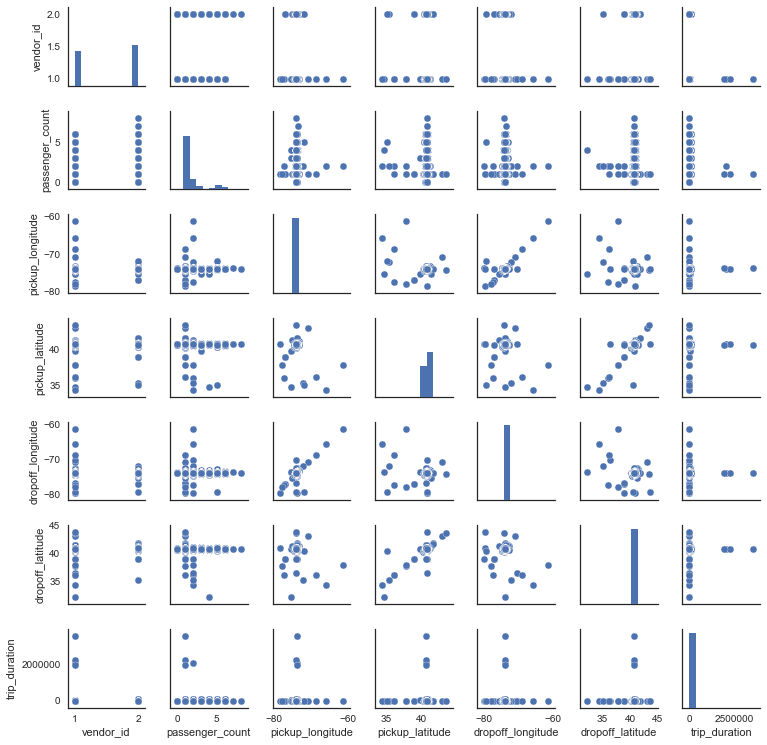

In [7]:
with plt.style.context(('seaborn-white')):
    sns_plot = sns.pairplot(train_orig, size=1.5)

plt.show() 

In [3]:
train_orig[['passenger_count', 'trip_duration']].describe()

,passenger_count,trip_duration
count,701778.000000,7.017780e+05
mean,1.666577,9.387318e+02
std,1.319466,6.772504e+03
min,0.000000,1.000000e+00
25%,1.000000,3.900000e+02
50%,1.000000,6.480000e+02
75%,2.000000,1.047000e+03
max,8.000000,3.526282e+06


In [2]:
train_orig.groupby('vendor_id').size()

vendor_id
1    325599
2    376179
dtype: int64

In [4]:
train_orig.groupby('passenger_count').size()

passenger_count
0        31
1    497800
2    100422
3     28321
4     13568
5     38131
6     23503
7         1
8         1
dtype: int64

In [4]:
train_orig.groupby('store_and_fwd_flag').size()

store_and_fwd_flag
N    697920
Y      3858
dtype: int64

### 2.2 데이터 추가

* 정확한 예측을 위해서는 추가적인 데이터가 필요
* 택시 운행시간에 영향을 미칠 만한 요소들 : 거리, 탑승/하차 지역의 교통량, 날씨, 탑승 시간대, 기사의 운전습관 등

**(1) 거리**

#### 1) 직선거리
> 직선거리 = r x arccos(sin(위도1) x sin(위도2) + cos(위도1) x cos(위도2) x cos(경도차))

> 지구 반지름(r) : 6378.137km

> Geopy package

In [ ]:
from geopy.distance import vincenty

distance = []

for i in range(N + 1):
    a, b = train_orig.loc[i]['pickup_latitude'], train_orig.loc[i]['pickup_longitude']
    pickup = (a, b)
    c, d = train_orig.loc[i]['dropoff_latitude'], train_orig.loc[i]['dropoff_longitude']
    dropoff = (c, d)
    
    distance.append(vincenty(pickup, dropoff).meters)
    
train_orig['geopy_distance'] = distance

#### 2) Manhattan Distance (Taxicab Geometry)
> Manhattan distance = | 위도차\_도 x 111 + 위도차\_분 x 1.85 + 위도차\_초 x 0.031 | + | 경도차\_도 x 88.8 + 경도차\_분 x 1.48 + 경도차\_초 x 0.025 |

![vs](http://www.improvedoutcomes.com/docs/WebSiteDocs/image/diagram_euclidean_manhattan_distance_metrics.gif)

In [43]:
import math

dif_long = abs(train_orig['dropoff_longitude'] - train_orig['pickup_longitude'])
dif_lat = abs(train_orig['dropoff_latitude'] - train_orig['pickup_latitude'])
tmp_long_do = dif_long.astype(int)
dif_long -= tmp_long_do
dif_long *=60
tmp_long_min = dif_long.astype(int)
dif_long -= tmp_long_min
tmp_long_sec = dif_long * 60
tmp_lat_do = dif_lat.astype(int)
dif_lat -= tmp_lat_do
tmp_lat_min = (dif_lat * 60).astype(int)
dif_lat *=60
dif_lat -= tmp_lat_min
tmp_lat_sec = dif_lat * 60

train_orig['taxi_distance'] = ((abs(tmp_lat_do * 111 + tmp_lat_min * 1.85 + tmp_lat_sec * 0.031) + \
                       abs(tmp_long_do * 88.8 + tmp_long_min * 1.48 + tmp_long_sec * 0.025)) * 1000) / math.cos(math.radians(61))

#### 3) Google Directions API
> 위도, 경도 정보를 이용하여 Google API에서 거리, 주소 정보를 얻음

In [ ]:
import googlemaps

gmaps = googlemaps.Client(key='API Key')

def get_directions(df):
    try:
        origin = (df['pickup_latitude'], df['pickup_longitude'])
        destination = (df['dropoff_latitude'], df['dropoff_longitude'])

        response = gmaps.directions(origin, destination, mode="driving", units="metric")

        df['api'] = response[0]['legs']

        return df
    
    except IndexError as err:
        print(err, df['id'])
        return None

**(2) 승/하차 좌표 클러스터링**

* 뉴욕시의 geojson 자료와 geopandas 패키지를 이용하여 승/하차 좌표를 클러스터링

<img src="http://www.ufoa.org/statistics/maps/citywideLarge.jpg" width="400" align = "left">

**1) 뉴욕시를 5개의 구역으로 클러스터링 (Manhattan, Bronx, Brooklyn, Queens, Staten Island)**

<img src="./image/5.png" width="400" height="400" align = "left"></img>

**2) 뉴욕시를 65개 구역으로 클러스터링**


<img src="./image/65.png" width="400" height="400" align = "left"></img>

In [ ]:
import geopandas as gpd
from shapely.geometry import Point
from geopandas.tools import sjoin

df = pd.read_csv('data/train.csv', usecols=['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_bname', 'dropoff_bname'])

cjson = gpd.read_file('/Users/youncheol/DSS/Projects/nyc_taxi/data/nyc-maps/state_assembly.geojson')

ppoint = gpd.GeoSeries(df.apply(lambda z : Point(z['pickup_longitude'], z['pickup_latitude']), axis=1), crs={'init': 'epsg:4326'})
dpoint = gpd.GeoSeries(df.apply(lambda z : Point(z['dropoff_longitude'], z['dropoff_latitude']), axis=1), crs={'init': 'epsg:4326'})

df = gpd.GeoDataFrame(df, geometry=ppoint)
df.rename(columns={"geometry" : "pgeometry"}, inplace=True)
df = gpd.GeoDataFrame(df, geometry=dpoint)
df.rename(columns={"geometry" : "dgeometry"}, inplace=True)

df.rename(columns={"pgeometry" : "geometry"}, inplace=True)
df.set_geometry('geometry')

df = gpd.sjoin(df, cjson, how='left', op='within')

df.rename(columns={"geometry" : "pgeometry"}, inplace=True)

df.rename(columns={"dgeometry" : "geometry"}, inplace=True)
df.set_geometry('geometry')

df = gpd.sjoin(df, cjson, how='left', op='within')

df.rename(columns={"geometry" : "dgeometry"}, inplace=True)

**(3) 시간대 / 요일 변수 추가**
  * pickup_datetime, dropoff_datatime 컬럼에서 시간대, 요일 정보만 추출

In [15]:
train['hour'] = train['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y %H:%M').hour)
train['weekday'] = train['pickup_datetime'].apply(lambda x: datetime.datetime.strptime(x, '%m/%d/%y %H:%M').weekday())

**(4) 교통량**
  * 승/하차 구간의 데이터 건수가 많을수록 택시 운행 빈도가 높으므로, 교통량이 많을 것이라고 가정

In [ ]:
train['count1'] = train.groupby(['pickup_bname', 'dropoff_bname'])['id'].transform('count')
train['count2'] = train.groupby(['p_code', 'd_code'])['id'].transform('count')

## 3. 이상치 제거

  - passenger_count가 0인 것 제거
  - 이동거리가 1m 이하인 것 제거
  - 평균 속도가 104km/h 이상인 것 제거 (뉴욕 고속도로의 제한속도)
  - 평균 속도가 2km/h 이하인 것 제거 (뉴욕 실시간 차량 속도에서 보이는 최저치)
  - 좌표가 바다를 가리키는 데이터 (la < 0.69301651 * long + 87.20951935)
  - trip_duration이 10초 이하인 것 제거
  - trip_duration이 24시간 이상인 것 제거

In [26]:
f = (train['trip_duration'] < 86400) & \
    (train['passenger_count'] != 0) & \
    (train['google_distance'] > 1) & \
    (train['google_distance'] / train['trip_duration'] * 3.6 < 104) & \
    (train['google_distance'] / train['trip_duration'] * 3.6 >= 2) & \
    (train['pickup_latitude'] > 0.69301651 * train['pickup_longitude'] + 87.20951935) & \
    (train['dropoff_latitude'] > 0.69301651 * train['dropoff_longitude'] + 87.20951935) & \
    (train['trip_duration'] > 10)

train = train[f]

## 4. EDA

* 거리와 소요시간 간의 Scatter Plot

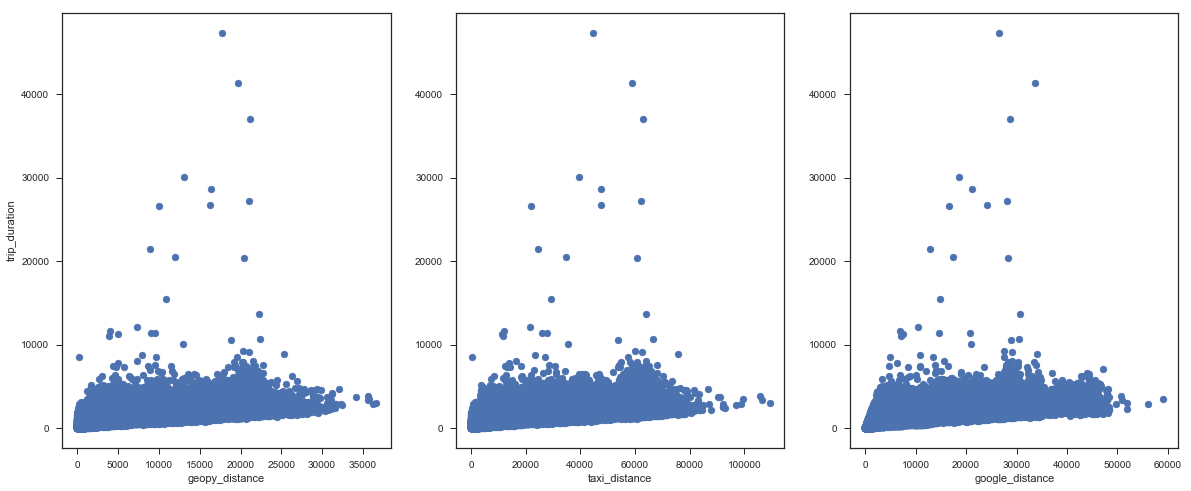

In [27]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.scatter(train.geopy_distance, train.trip_duration)
plt.ylabel('trip_duration')
plt.xlabel('geopy_distance')
plt.subplot(1,3,2)
plt.scatter(train.taxi_distance, train.trip_duration)
plt.xlabel('taxi_distance')
plt.subplot(1,3,3)
plt.scatter(train.google_distance, train.trip_duration)
plt.xlabel('google_distance')

* 거리와 소요시간 간의 상관관계

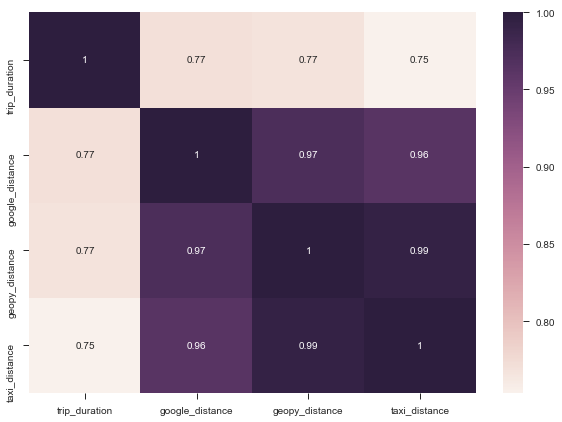

In [10]:
plt.figure(figsize=(10, 7))
sns.heatmap(train[['trip_duration', 'google_distance', 'geopy_distance', 'taxi_distance']].corr(), annot=True)

* vendor_id

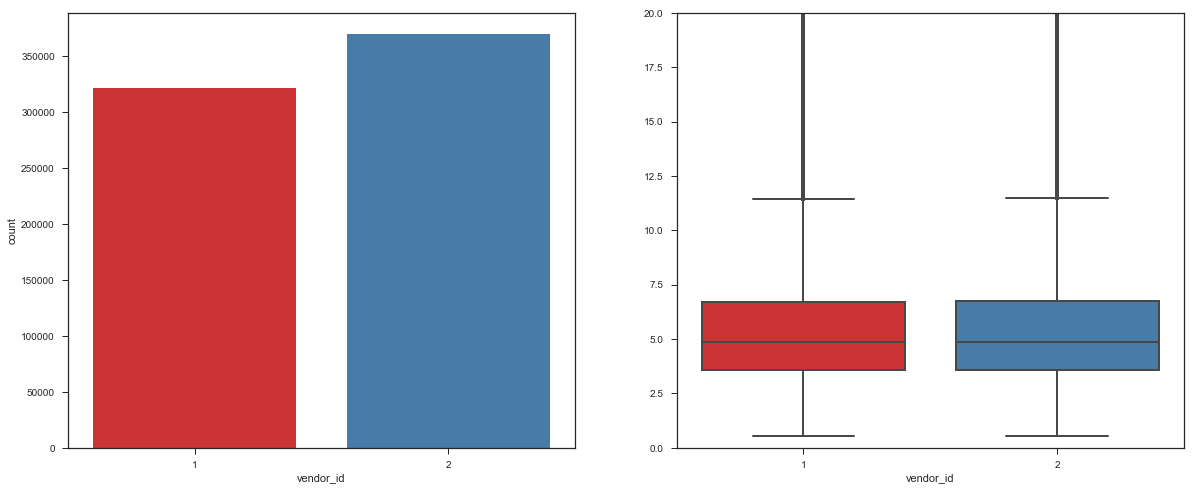

In [11]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
with plt.style.context(('seaborn-white')):
    sns.countplot(train['vendor_id'], linewidth=2, palette="Set1")
plt.subplot(1,2,2)
with plt.style.context(('seaborn-white')):
    sns.boxplot(x=train['vendor_id'], y=train['google_distance'] / train['trip_duration'], linewidth=2, palette="Set1")
    plt.ylim(0, 20)

* passenger_count

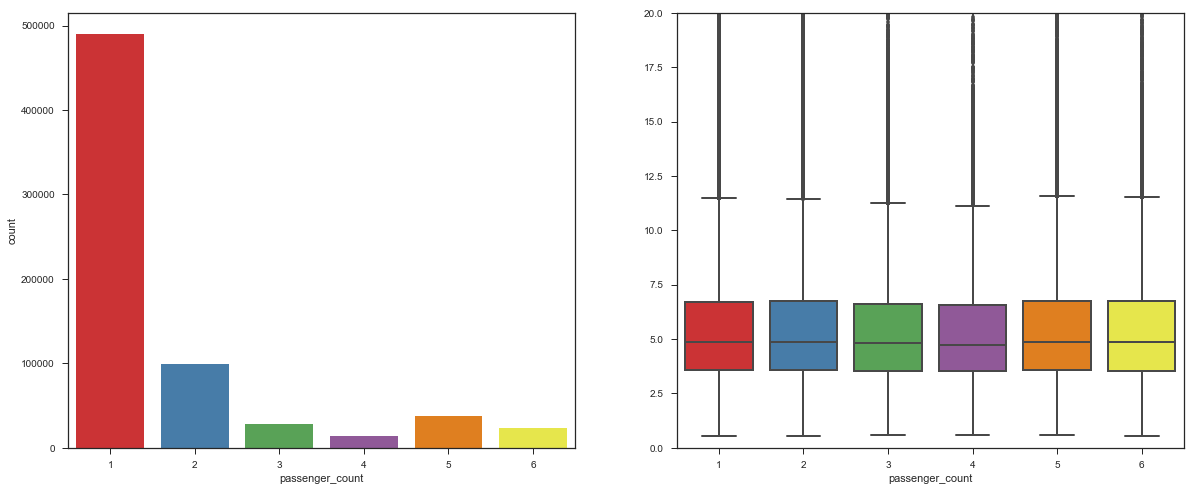

In [12]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
with plt.style.context(('seaborn-white')):
    sns.countplot(train['passenger_count'], linewidth=2, palette="Set1")
plt.subplot(1,2,2)
with plt.style.context(('seaborn-white')):
    sns.boxplot(x=train['passenger_count'], y=train['google_distance'] / train['trip_duration'], linewidth=2, palette="Set1")
    plt.ylim(0, 20)

* store_and_fwd_flag

(0, 20)

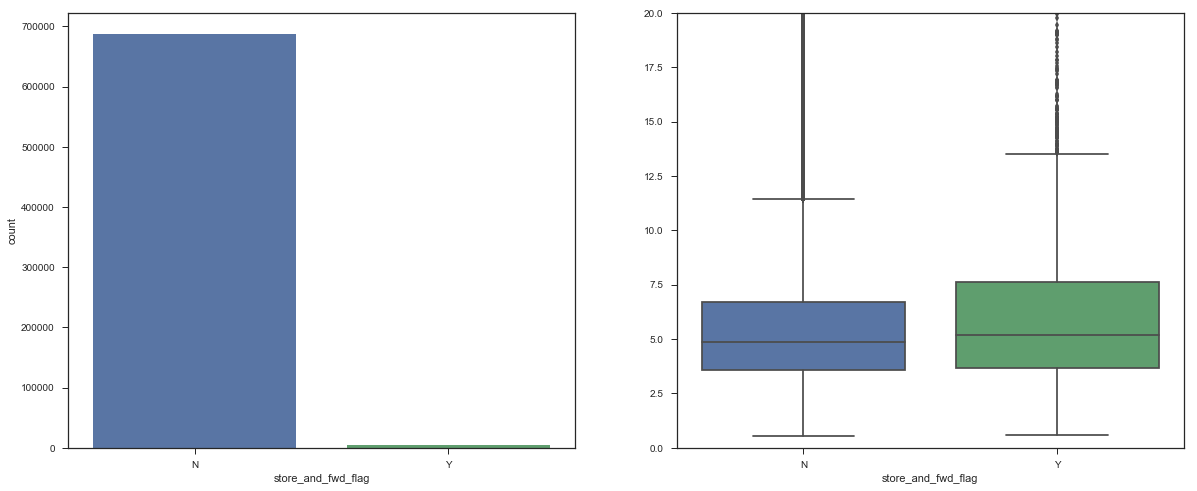

In [13]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
with plt.style.context(('seaborn-white')):
    sns.countplot(train['store_and_fwd_flag'])
plt.subplot(1,2,2)
with plt.style.context(('seaborn-white')):
    sns.boxplot(x=train['store_and_fwd_flag'], y=train['google_distance'] / train['trip_duration'])
plt.ylim(0, 20)

* pickup_date

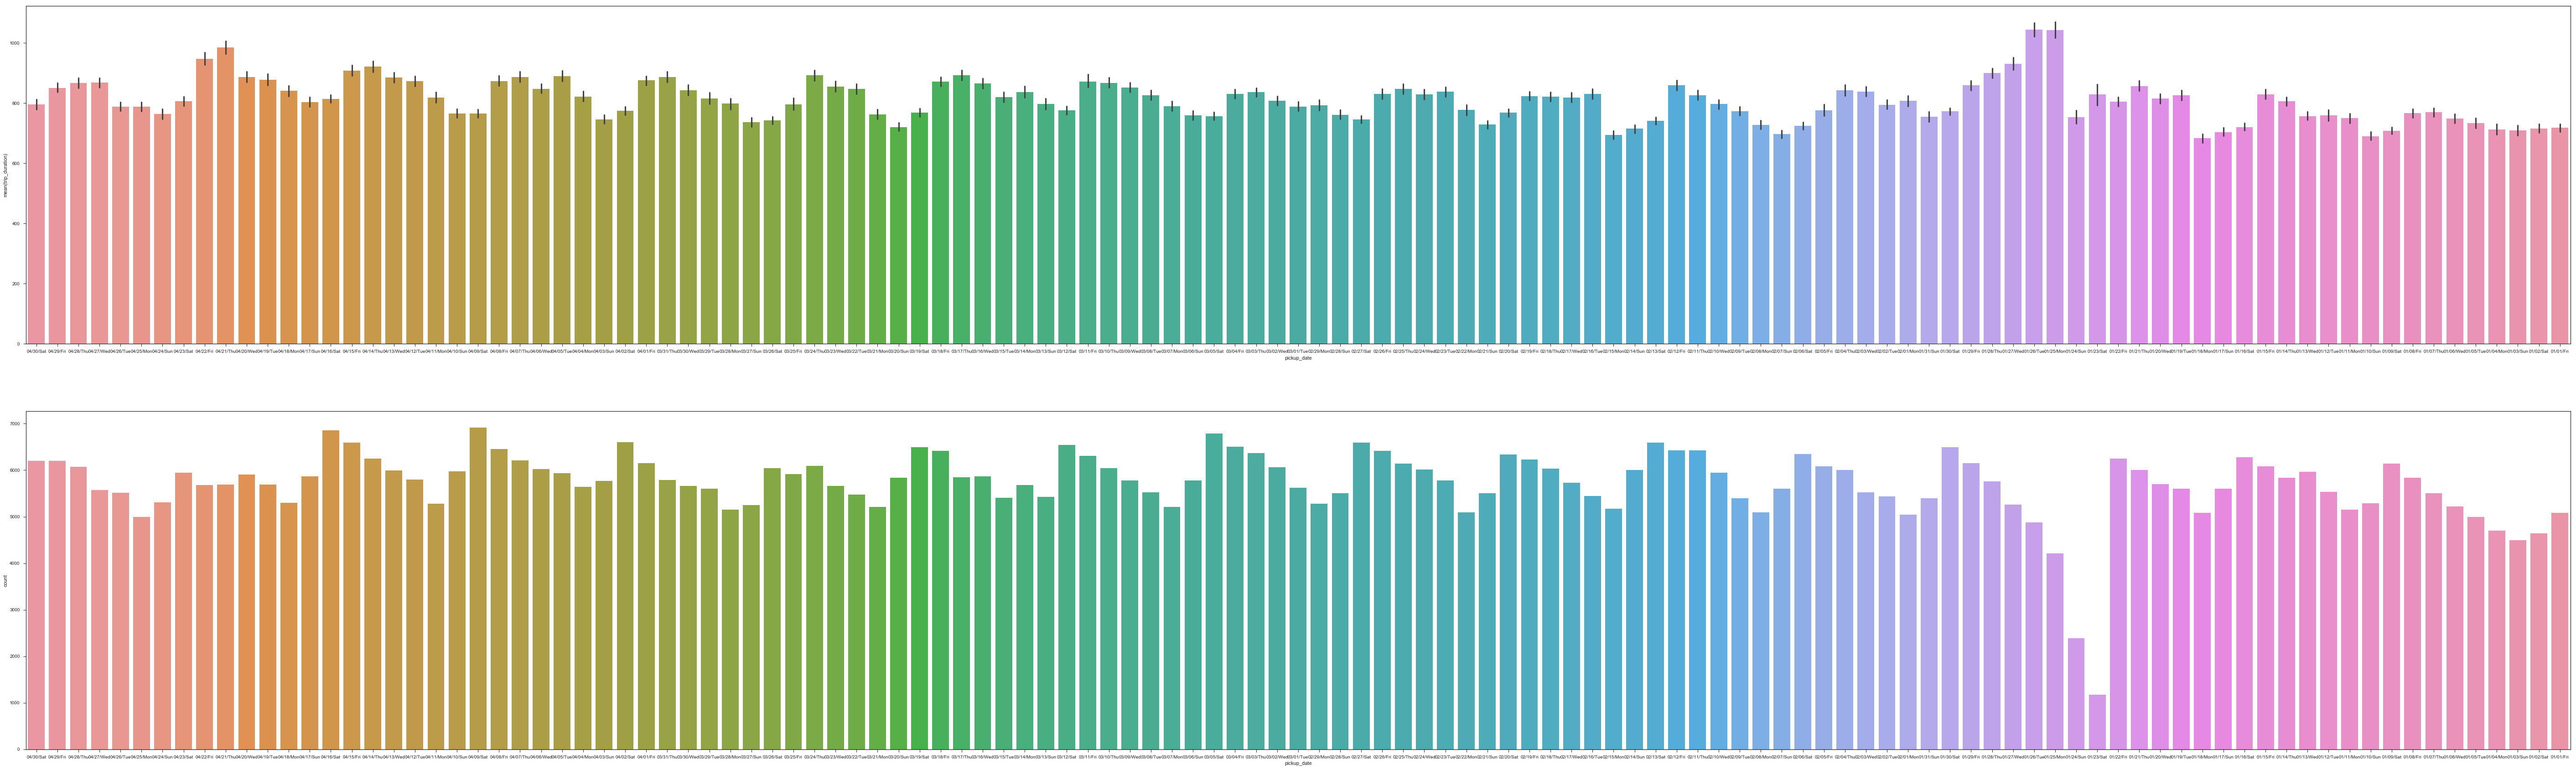

In [16]:
df_split = train['pickup_datetime'].str.split(' ', expand=True)
df_time = df_split[1].str.split(':', expand=True)

train['pickup_date'] = pd.to_datetime(df_split[0], format='%m/%d/%y')

plt.figure(figsize=(100,30))
plt.subplot(2,1,1)
with plt.style.context(('seaborn-white')):
    sns.barplot(x=train['pickup_date'].dt.strftime('%m/%d/%a'), y=train['trip_duration'])
plt.subplot(2,1,2)
with plt.style.context(('seaborn-white')):
    sns.countplot(x=train['pickup_date'].dt.strftime('%m/%d/%a'))

* hour

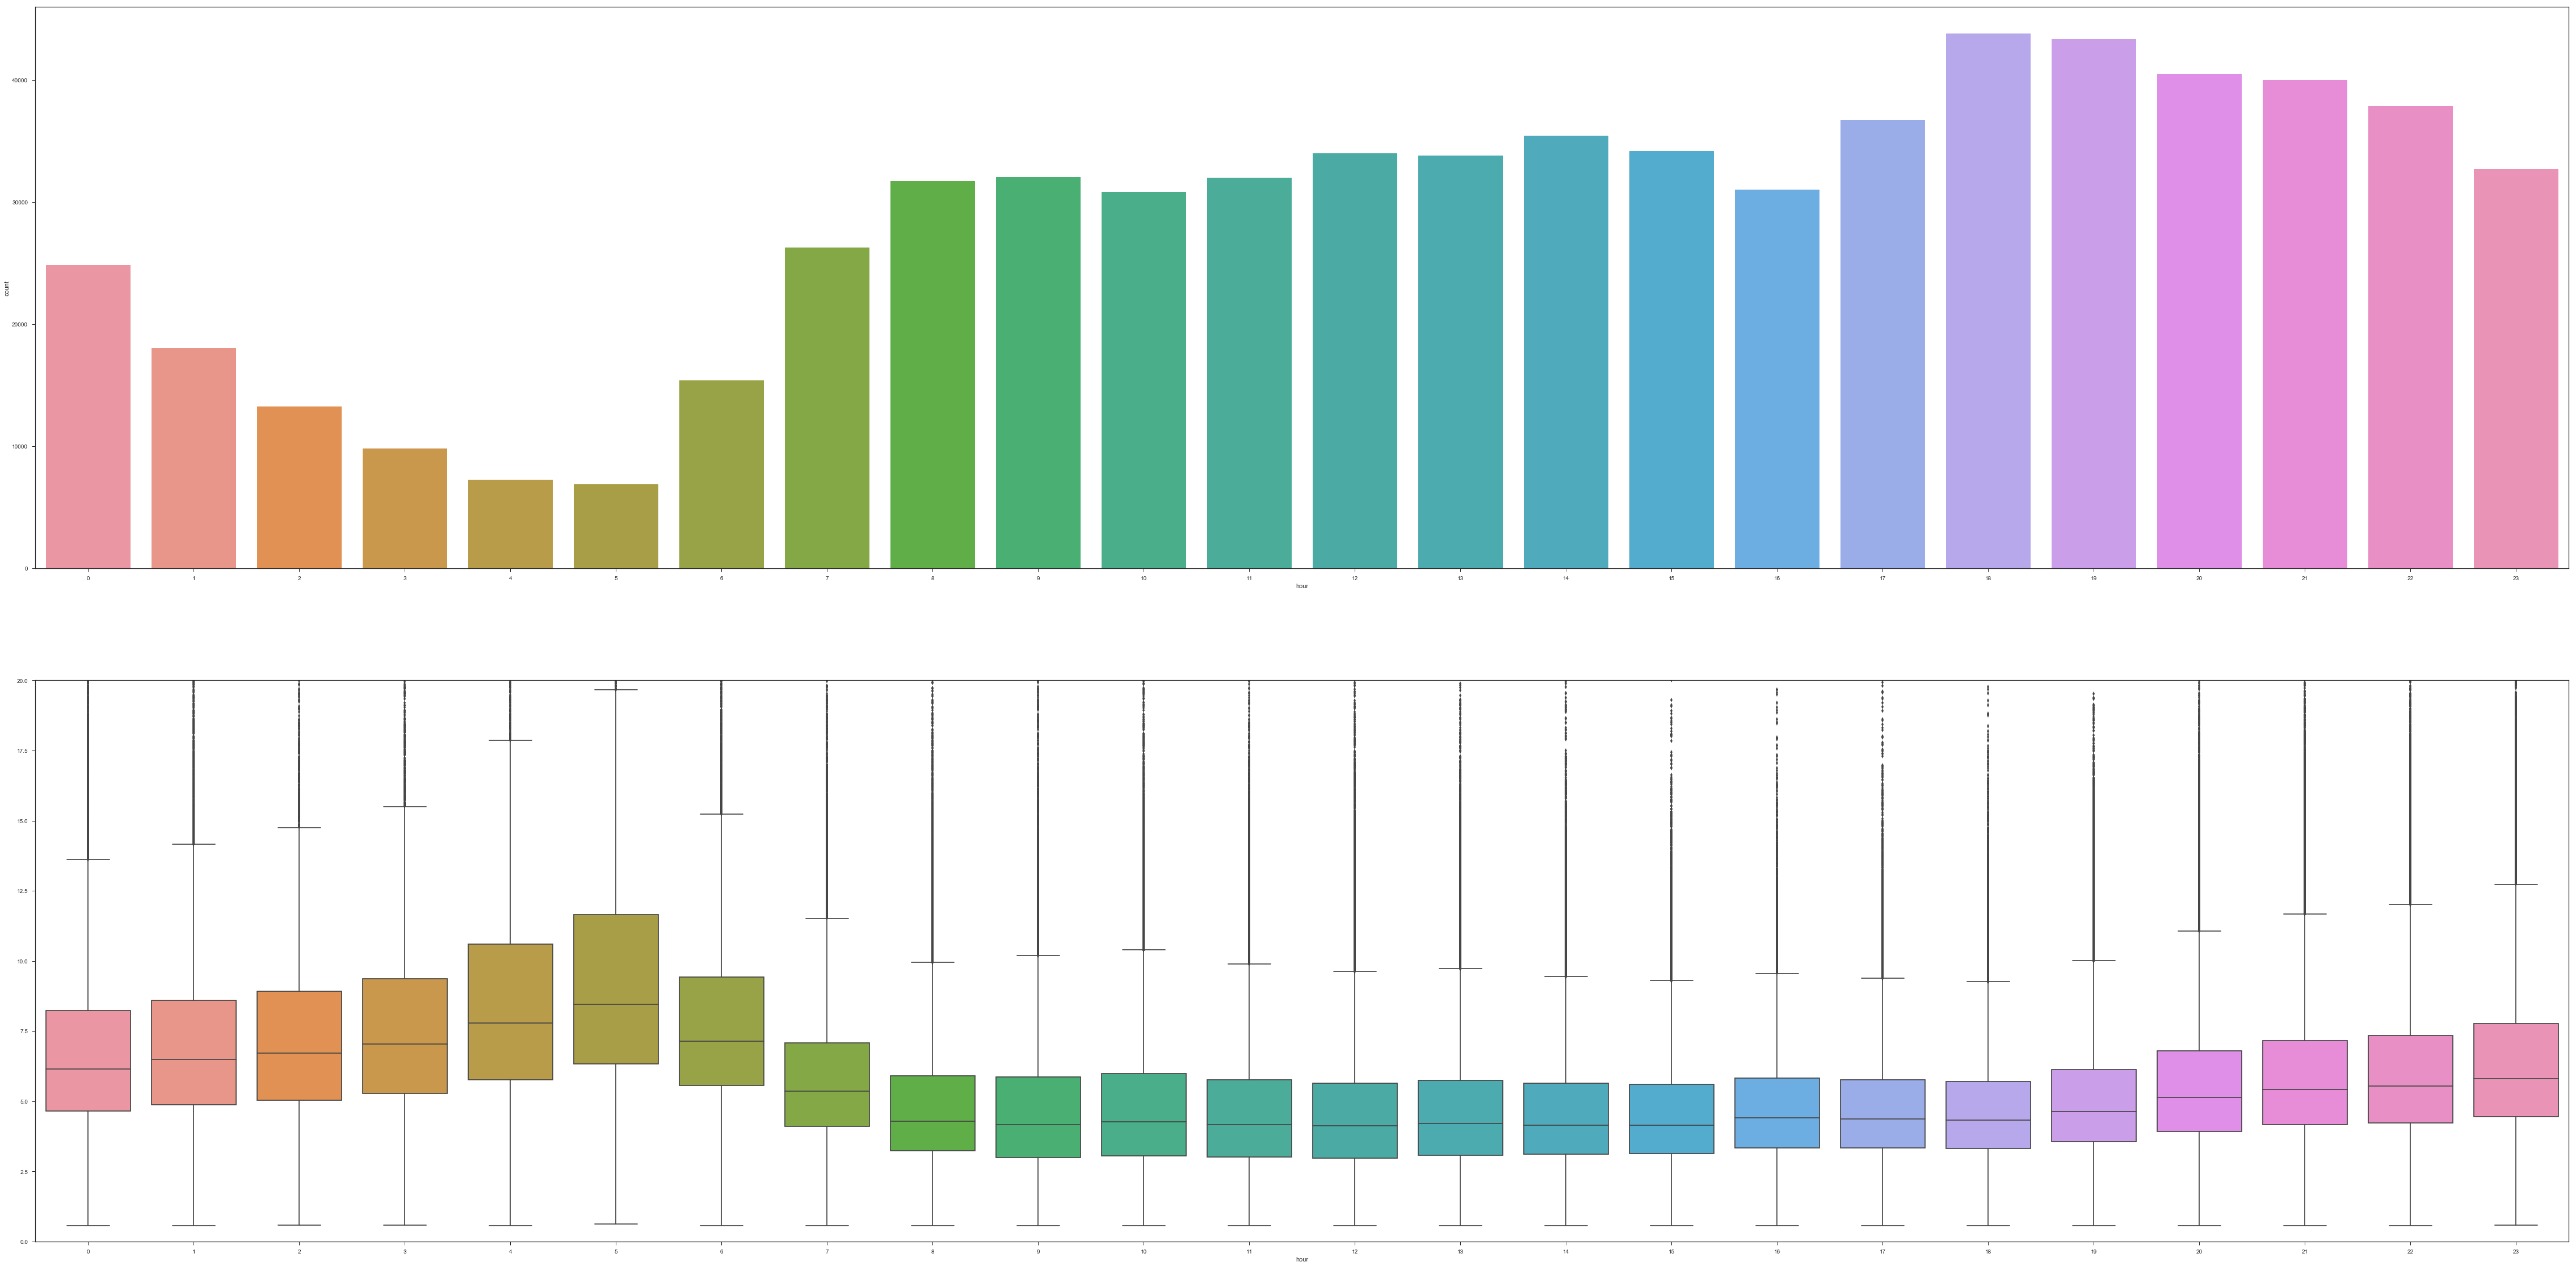

In [17]:
plt.figure(figsize=(80,40))
plt.subplot(2,1,1)
with plt.style.context(('seaborn-white')):
    sns.countplot(train['hour'])
    plt.xlabel('hour')
plt.subplot(2,1,2)
with plt.style.context(('seaborn-white')):
    sns.boxplot(x=train['hour'], y=train['google_distance'] / train['trip_duration'])
    plt.xlabel('hour')
    plt.ylim(0, 20)

* weekday / weekend

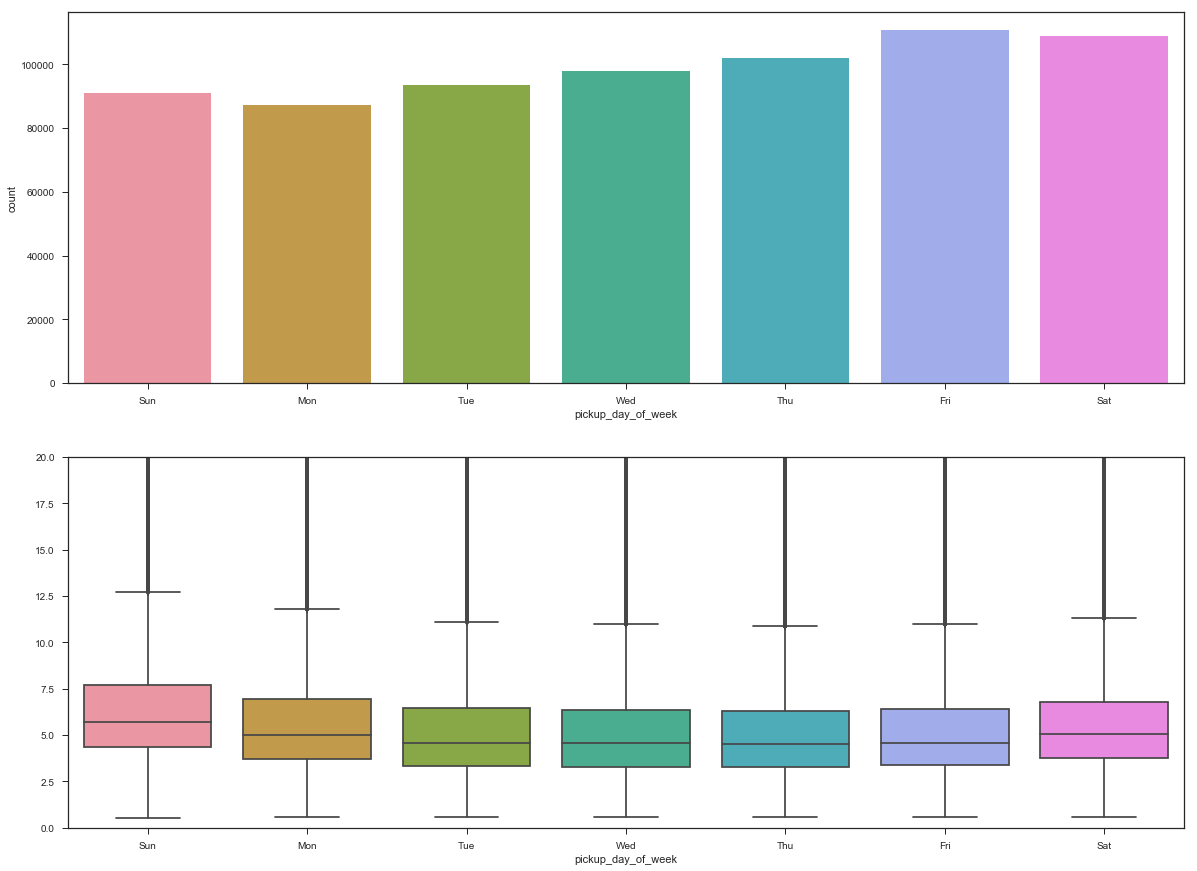

In [18]:
plt.figure(figsize=(20,15))
plt.subplot(2,1,1)
with plt.style.context(('seaborn-white')):
    sns.countplot(train['pickup_date'].dt.strftime('%a'), order=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    plt.xlabel('pickup_day_of_week') 
plt.subplot(2,1,2)
with plt.style.context(('seaborn-white')):
    sns.boxplot(x=train['pickup_date'].dt.strftime('%a'), order=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'], y=train['google_distance'] / train['trip_duration'])
    plt.xlabel('pickup_day_of_week')
    plt.ylim(0, 20)

* longitude, latitude

/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


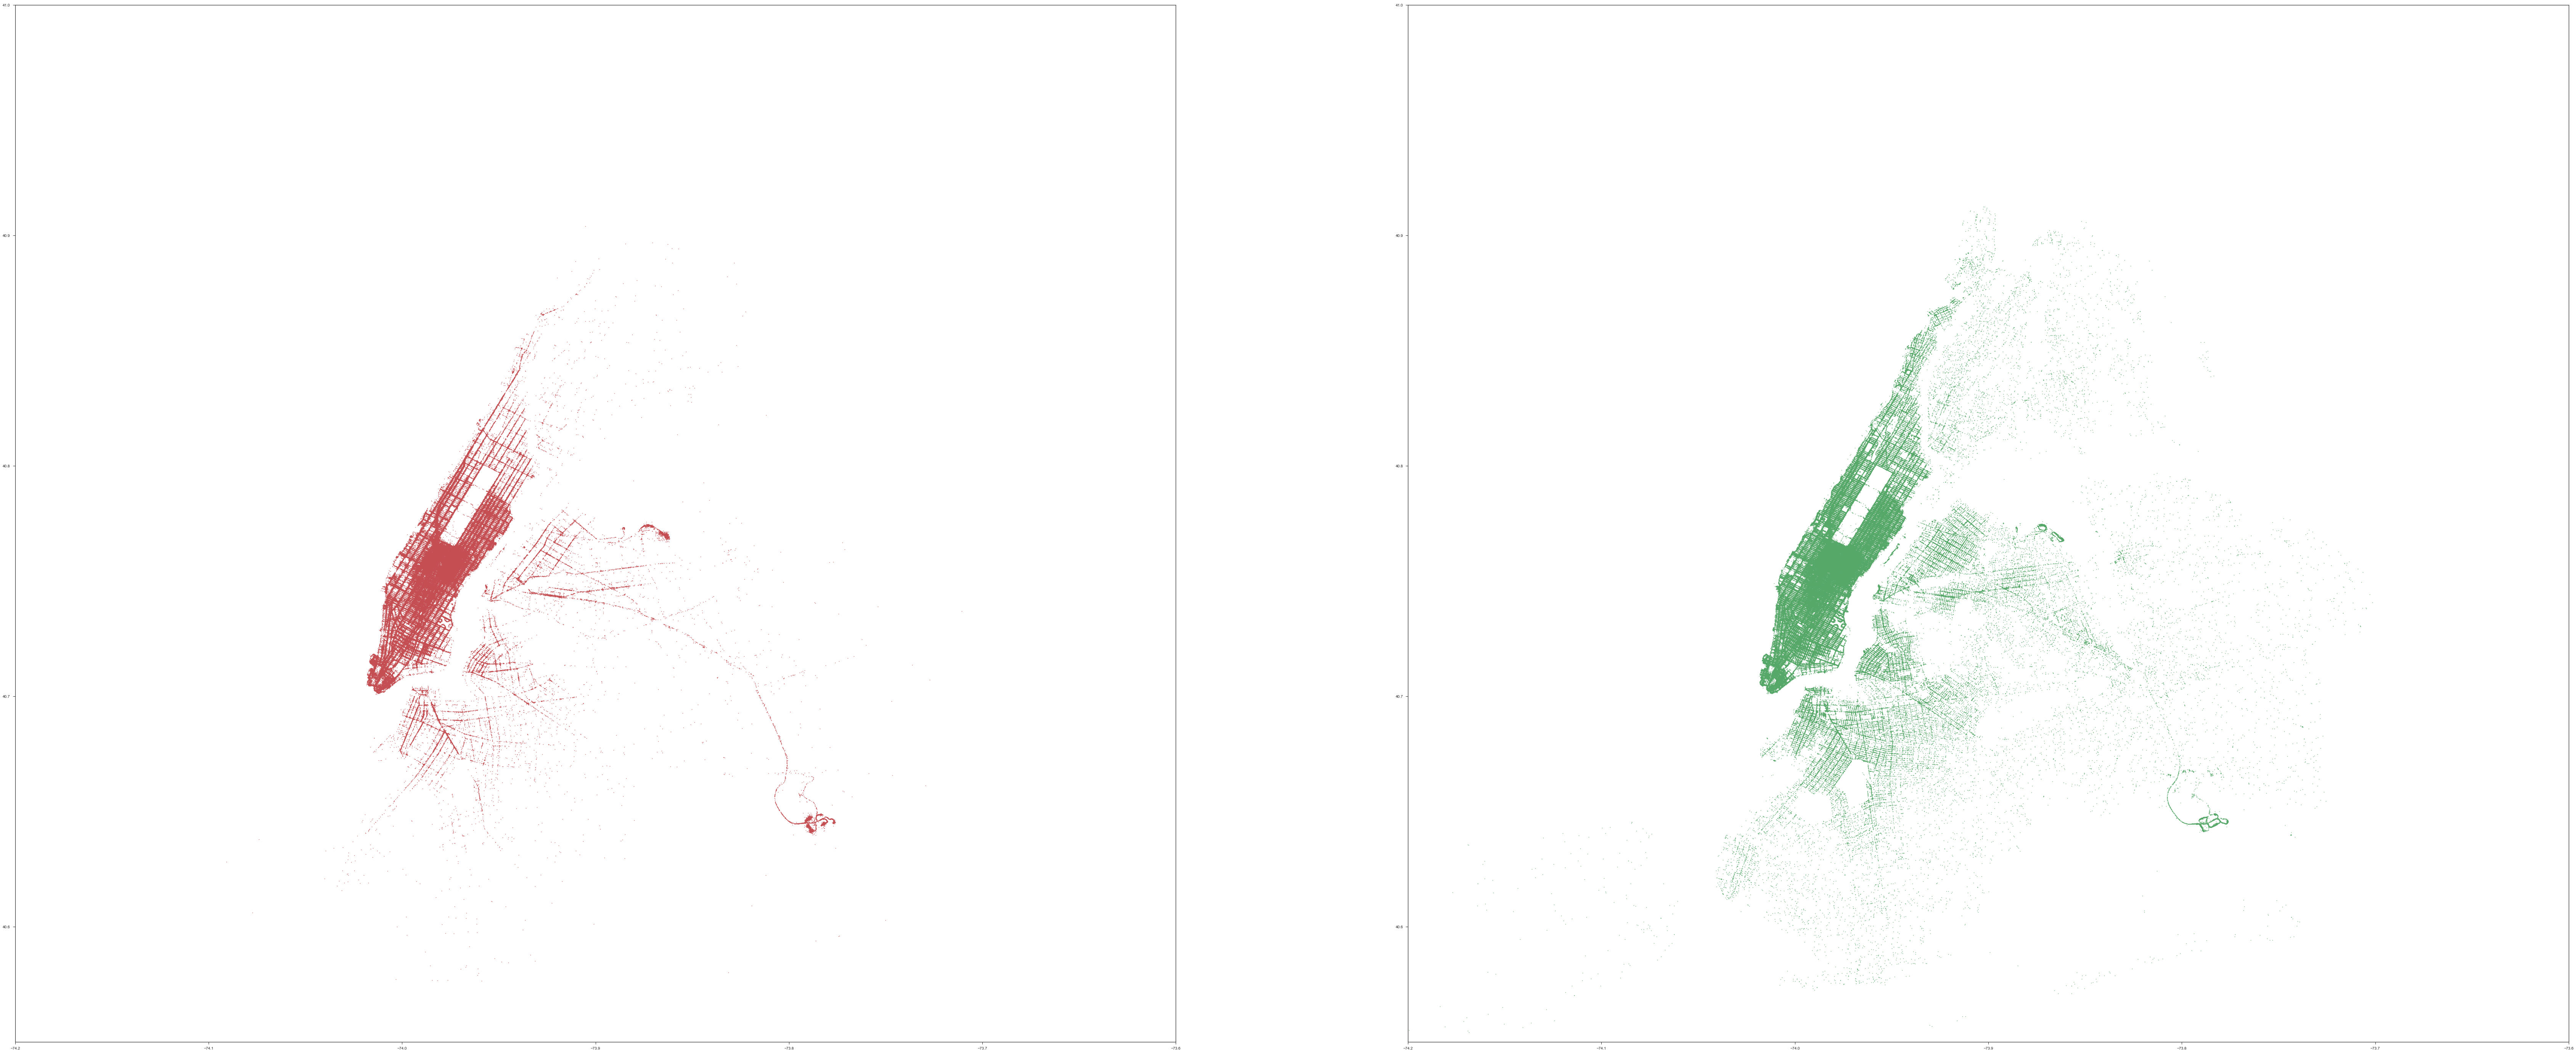

In [19]:
fig = plt.figure(figsize=(120,50))
axes = fig.add_axes([0.0, 0.0, 2.0, 2.0])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.subplot(1,2,1)
plt.xlim(-74.2, -73.6)
plt.ylim(40.55, 41)
plt.scatter(train['pickup_longitude'], train['pickup_latitude'], label='Pick up',alpha=1, s=1.5, c='r')
axes.legend(loc='best')
plt.subplot(1,2,2)
plt.xlim(-74.2, -73.6)
plt.ylim(40.55, 41)
plt.scatter(train['dropoff_longitude'], train['dropoff_latitude'], label='Drop off', alpha=1, s=1.5, c='g')
axes.legend(loc='best')

## 5. 변수 선택 및 변환

 * vendor_id, passenger_count, store_and_fwd_flag는 소요시간에 미치는 영향이 적다고 판단
 * EDA 결과 유의하다고 판단되는 변수 선택 : duration, hour, weekday, count

In [21]:
train.head(1)

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,geopy_distance,google_distance,pickup_bname,dropoff_bname,...,p_code,d_code,count2,taxi_distance,vendor_id,passenger_count,store_and_fwd_flag,pickup_datetime,dropoff_datetime,pickup_date
0,id3495688,-73.987793,40.724792,-73.975616,40.656445,1454,7659.36537,11934.0,Manhattan,Brooklyn,...,66.0,44.0,279,17911.185186,1,1,N,4/30/16 23:59,5/1/16 0:24,2016-04-30


* 회귀분석 성능 향상을 위해 분포가 치우친 변수들에 log를 취해줌

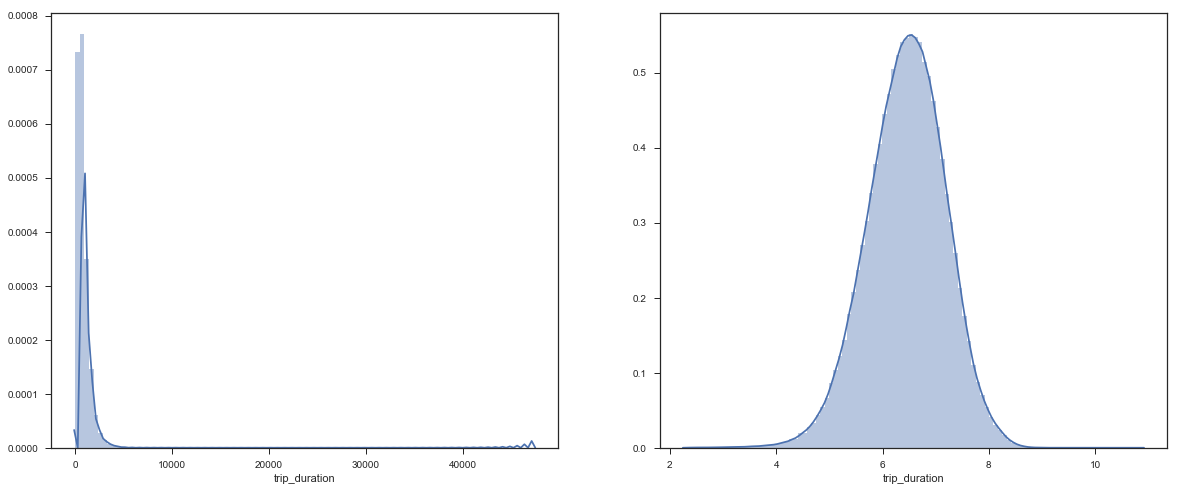

In [22]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(train['trip_duration'], bins=100)
plt.subplot(1,2,2)
sns.distplot(np.log(train['trip_duration']), bins=100)

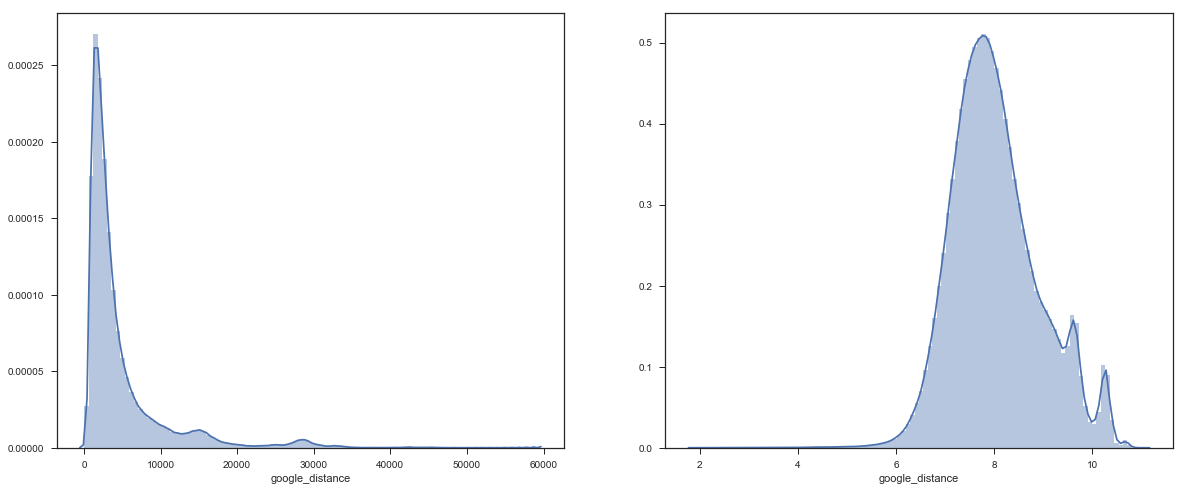

In [23]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
sns.distplot(train['google_distance'], bins=100)
plt.subplot(1,2,2)
sns.distplot(np.log(train['google_distance']), bins=100)

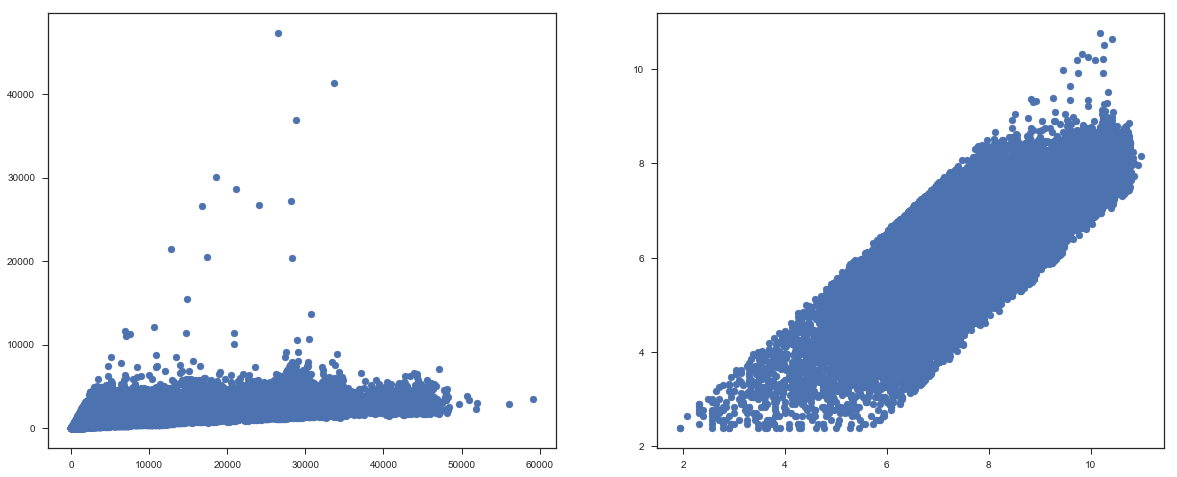

In [28]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.scatter(train['google_distance'], train['trip_duration'])
plt.subplot(1,2,2)
plt.scatter(np.log(train['google_distance']), np.log(train['trip_duration']))

## 6. 모형 성능 비교

 ###    6.1 OLS 회귀 분석

* **geopy_distance, taxi_distance, google_distance의 OLS 결과 비교**

In [29]:
model = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(geopy_distance)) + C(hour) + C(weekday)", data=train)

result = model.fit()
print(result.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.689
Model:                               OLS   Adj. R-squared:                  0.689
Method:                    Least Squares   F-statistic:                 5.113e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           09:27:27   Log-Likelihood:            -3.6066e+05
No. Observations:                 691663   AIC:                         7.214e+05
Df Residuals:                     691632   BIC:                         7.217e+05
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

In [30]:
model = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(taxi_distance)) + C(hour) + C(weekday)", data=train)

result = model.fit()
print(result.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.670
Model:                               OLS   Adj. R-squared:                  0.670
Method:                    Least Squares   F-statistic:                 4.685e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           09:27:44   Log-Likelihood:            -3.8124e+05
No. Observations:                 691663   AIC:                         7.625e+05
Df Residuals:                     691632   BIC:                         7.629e+05
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [31]:
model = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(google_distance)) + C(hour) + C(weekday)", data=train)

result = model.fit()
print(result.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.726
Model:                               OLS   Adj. R-squared:                  0.726
Method:                    Least Squares   F-statistic:                 6.116e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           09:28:04   Log-Likelihood:            -3.1683e+05
No. Observations:                 691663   AIC:                         6.337e+05
Df Residuals:                     691632   BIC:                         6.341e+05
Df Model:                             30                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

* **뉴욕을 5개 영역으로 나눈 모델 vs 65개로 나눈 모델**

In [32]:
model1 = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(google_distance)) + scale(count1) + \
                             C(hour) + C(weekday)", data=train)

result1 = model1.fit()
print(result1.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.729
Model:                               OLS   Adj. R-squared:                  0.729
Method:                    Least Squares   F-statistic:                 6.009e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           09:28:53   Log-Likelihood:            -3.1299e+05
No. Observations:                 691663   AIC:                         6.260e+05
Df Residuals:                     691631   BIC:                         6.264e+05
Df Model:                             31                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [33]:
model2 = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(google_distance)) + scale(count2) + \
                             C(hour) + C(weekday)", data=train)

result2 = model2.fit()
print(result2.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.729
Model:                               OLS   Adj. R-squared:                  0.729
Method:                    Least Squares   F-statistic:                 6.008e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           09:29:35   Log-Likelihood:            -3.1303e+05
No. Observations:                 691663   AIC:                         6.261e+05
Df Residuals:                     691631   BIC:                         6.265e+05
Df Model:                             31                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

### 6.2 변수 중요도 비교

In [34]:
sm.stats.anova_lm(result1, typ=2)

,sum_sq,df,F,PR(>F)
C(hour),11887.051511,23.0,3.570641e+03,0.0
C(weekday),2684.521431,6.0,3.091117e+03,0.0
scale(np.log(google_distance)),196122.397242,1.0,1.354962e+06,0.0
scale(count1),1118.400350,1.0,7.726756e+03,0.0
Residual,100109.332526,691631.0,NaN,NaN


In [35]:
sm.stats.anova_lm(result2, typ=2)

,sum_sq,df,F,PR(>F)
C(hour),12202.976801,23.0,3.665095e+03,0.0
C(weekday),2629.139483,6.0,3.026981e+03,0.0
scale(np.log(google_distance)),223317.373309,1.0,1.542659e+06,0.0
scale(count2),1106.276913,1.0,7.642072e+03,0.0
Residual,100121.455962,691631.0,NaN,NaN


## 7. 모형 검증

### 7.1 잔차의 정규성 검정

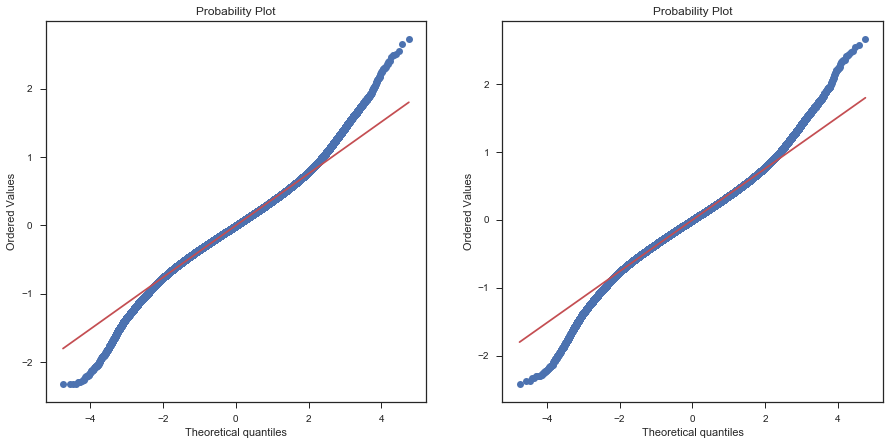

In [36]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1) 
sp.stats.probplot(result1.resid, plot=plt)
plt.subplot(1,2,2)
sp.stats.probplot(result2.resid, plot=plt)
plt.show()

In [37]:
test = sms.omni_normtest(result1.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 16483.752
P-value     :  0.000


In [38]:
test = sms.omni_normtest(result2.resid)
for xi in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % xi)

Chi^2       : 16156.538
P-value     :  0.000


### 7.2 Partial Regression Plot

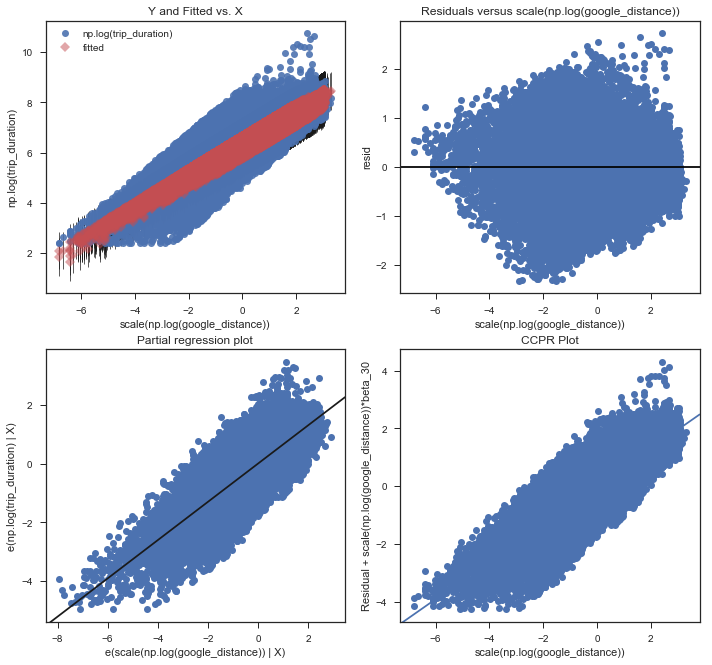

In [39]:
fig = plt.figure(figsize=(10, 10))
fig = sm.graphics.plot_regress_exog(result1, "scale(np.log(google_distance))", fig=fig)
fig.suptitle("")
plt.show()

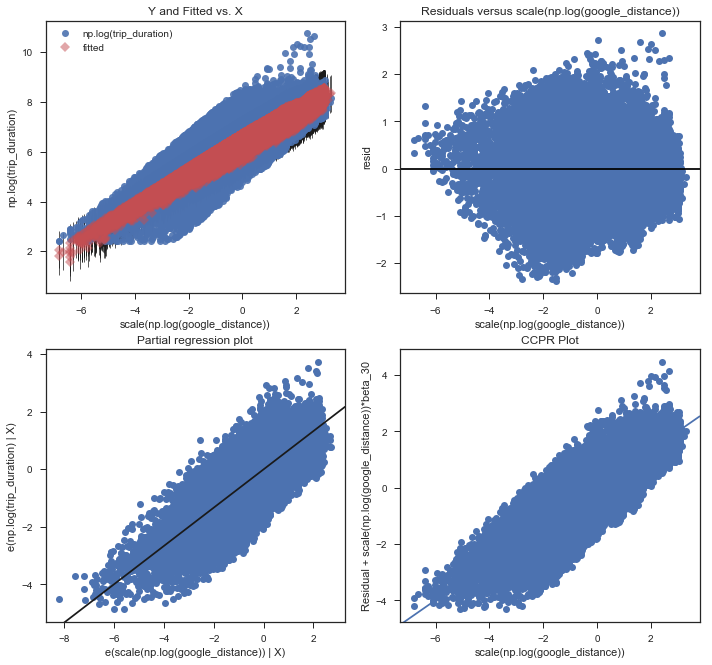

In [129]:
fig = plt.figure(figsize=(10, 10))
fig = sm.graphics.plot_regress_exog(result2, "scale(np.log(google_distance))", fig=fig)
fig.suptitle("")
plt.show()

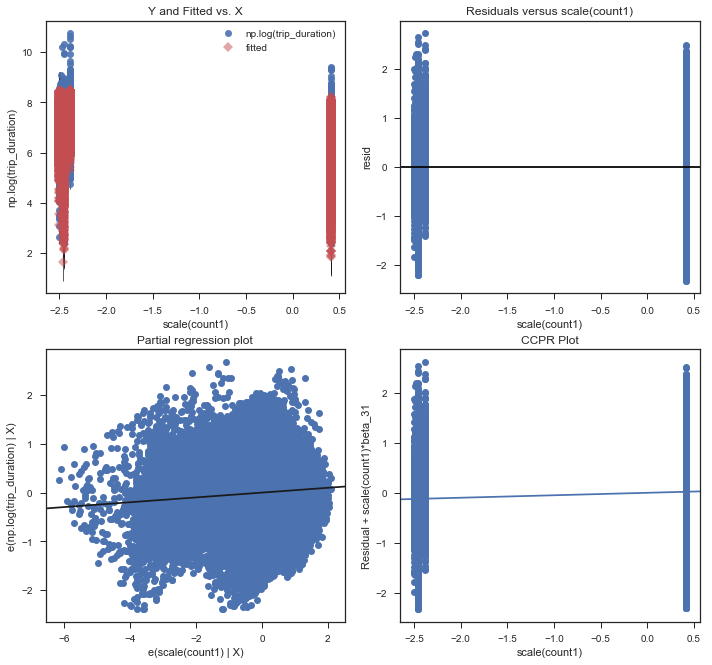

In [40]:
fig = plt.figure(figsize=(10, 10))
fig = sm.graphics.plot_regress_exog(result1, "scale(count1)", fig=fig)
fig.suptitle("")
plt.show()

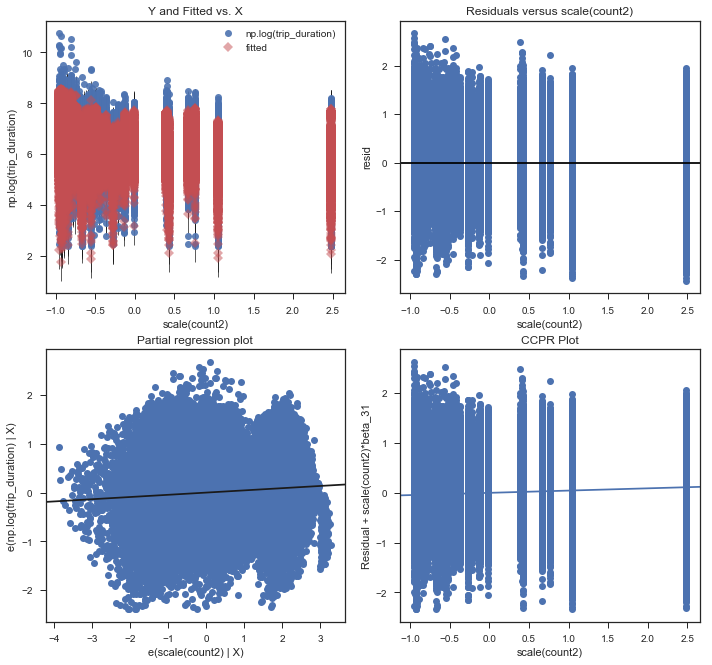

In [41]:
fig = plt.figure(figsize=(10, 10))
fig = sm.graphics.plot_regress_exog(result2, "scale(count2)", fig=fig)
fig.suptitle("")
plt.show()

* count1,2 변수에 log

In [42]:
model1 = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(google_distance)) + scale(np.log(count1)) + \
                             C(hour) + C(weekday)", data=train)

result1 = model1.fit()
print(result1.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.729
Model:                               OLS   Adj. R-squared:                  0.729
Method:                    Least Squares   F-statistic:                 6.013e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           09:32:05   Log-Likelihood:            -3.1286e+05
No. Observations:                 691663   AIC:                         6.258e+05
Df Residuals:                     691631   BIC:                         6.261e+05
Df Model:                             31                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

In [43]:
model2 = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(google_distance)) + scale(np.log(count2)) + \
                             C(hour) + C(weekday)", data=train)

result2 = model2.fit()
print(result2.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.732
Model:                               OLS   Adj. R-squared:                  0.732
Method:                    Least Squares   F-statistic:                 6.102e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           09:32:27   Log-Likelihood:            -3.0913e+05
No. Observations:                 691663   AIC:                         6.183e+05
Df Residuals:                     691631   BIC:                         6.187e+05
Df Model:                             31                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------

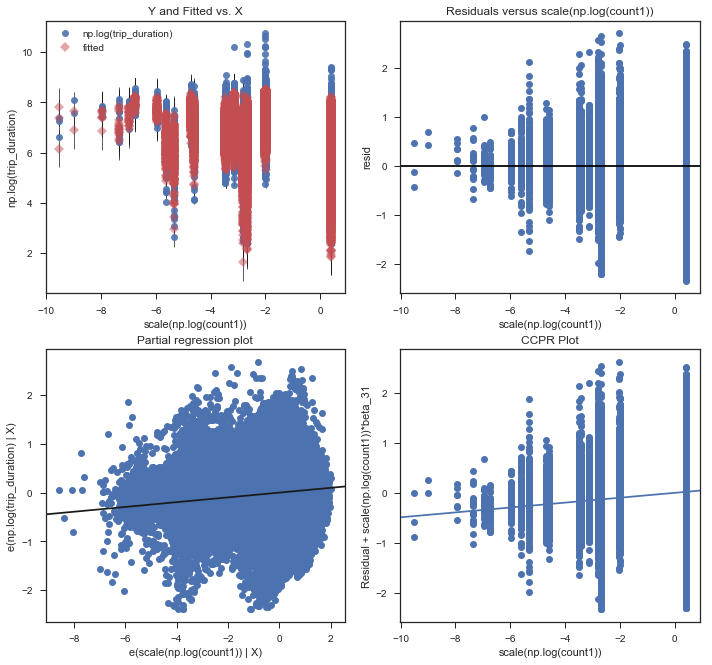

In [41]:
fig = plt.figure(figsize=(10, 10))
fig = sm.graphics.plot_regress_exog(result1, "scale(np.log(count1))", fig=fig)
fig.suptitle("")
plt.show()

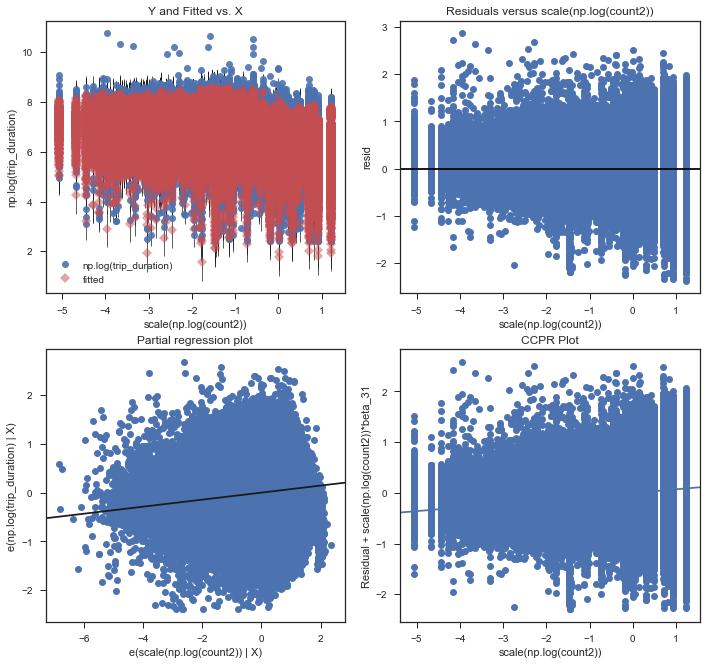

In [42]:
fig = plt.figure(figsize=(10, 10))
fig = sm.graphics.plot_regress_exog(result2, "scale(np.log(count2))", fig=fig)
fig.suptitle("")
plt.show()

### 7.3 다중공선성 확인

* **독립변수 간의 상관관계 확인**

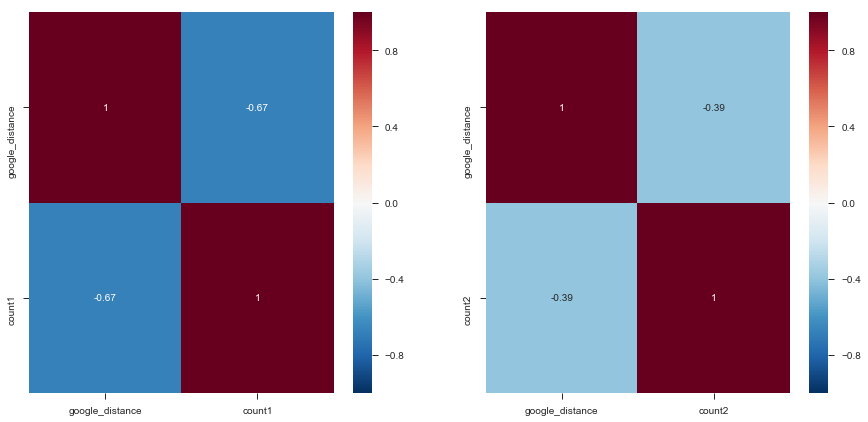

In [44]:
plt.figure(figsize=(15, 7))
plt.subplot(1,2,1) 
sns.heatmap(train[['google_distance', 'count1']].corr(), annot=True)
plt.subplot(1,2,2)
sns.heatmap(train[['google_distance', 'count2']].corr(), annot=True)
plt.show()

* **VIF 수치 비교**

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

dfX = train[['google_distance', 'count1', 'hour', 'weekday']]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,1.752753,google_distance
1,4.840735,count1
2,4.679507,hour
3,3.086744,weekday


In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

dfX = train[['google_distance', 'count2', 'hour', 'weekday']]

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,1.693746,google_distance
1,1.849979,count2
2,3.084464,hour
3,2.517067,weekday


### 7.4 Cross Validation

In [151]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

basis_fomula = 'np.log(trip_duration) ~ scale(np.log(google_distance)) + scale(count1) + C(hour) + C(weekday)'

N = 10

scores = np.zeros(N)
cv = KFold(N)

train_X = train[['trip_duration', 'google_distance', 'count1', 'hour', 'weekday']]
train_y = np.log(train['trip_duration'])

for i, (train_index, test_index) in enumerate(cv.split(train_X)):

    X_train = train_X.loc[train_index]
    y_train = train_y.loc[train_index]
    X_test = train_X.loc[test_index]
    y_test = train_y.loc[test_index]

    result = sm.OLS.from_formula(basis_fomula, data=X_train).fit()
    
    y_pred = result.predict(X_test) 
    
    scores[i] = np.sqrt(mean_squared_error(y_test, y_pred))

scores.mean(), scores.var(), scores

(0.38094319212840905,
 4.741201662137123e-05,
 array([ 0.39263903,  0.38357563,  0.38817597,  0.37983456,  0.37442165,
         0.37132841,  0.37955523,  0.37251439,  0.38887915,  0.37850791]))

In [153]:
basis_fomula = 'np.log(trip_duration) ~ scale(np.log(google_distance)) + scale(np.log(count2)) + C(hour) + C(weekday)'

N = 10

scores = np.zeros(N)
cv = KFold(N)

train_X = train[['trip_duration', 'google_distance', 'count2', 'hour', 'weekday']]
train_y = np.log(train['trip_duration'])

for i, (train_index, test_index) in enumerate(cv.split(train_X)):

    X_train = train_X.loc[train_index]
    y_train = train_y.loc[train_index]
    X_test = train_X.loc[test_index]
    y_test = train_y.loc[test_index]

    result = sm.OLS.from_formula(basis_fomula, data=X_train).fit()
    
    y_pred = result.predict(X_test) 
    
    scores[i] = np.sqrt(mean_squared_error(y_test, y_pred))

scores.mean(), scores.var(), scores

(0.37884449308337653,
 4.4309419473810524e-05,
 array([ 0.38984387,  0.38120854,  0.38518434,  0.37689759,  0.37218029,
         0.36950008,  0.37666278,  0.37125527,  0.38766564,  0.37804652]))

## 8. 최종 모델

In [29]:
model = sm.OLS.from_formula("np.log(trip_duration) ~ scale(np.log(google_distance)) + scale(np.log(count2)) + \
                             C(hour) + C(weekday)", data=train)

result = model.fit()
print(result.summary())

                              OLS Regression Results                             
Dep. Variable:     np.log(trip_duration)   R-squared:                       0.732
Model:                               OLS   Adj. R-squared:                  0.732
Method:                    Least Squares   F-statistic:                 6.102e+04
Date:                   Wed, 25 Oct 2017   Prob (F-statistic):               0.00
Time:                           08:37:52   Log-Likelihood:            -3.0913e+05
No. Observations:                 691663   AIC:                         6.183e+05
Df Residuals:                     691631   BIC:                         6.187e+05
Df Model:                             31                                         
Covariance Type:               nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------